In [1]:

%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#RUN BEFORE#

In [4]:
#RUN AFTER#

import tensorflow.keras as keras
K = keras.backend
from util.Models import *
from util.Generators import *


In [5]:

data_path = '/fast_scratch_1/atlas_images/v01-45/'

cell_geo_path = data_path + 'cell_geo.root'

out_path = '/fast_scratch_1/jlerner/data/'


In [6]:

K.clear_session()
model = GarNetModel()


2023-05-23 13:59:23.752524: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-05-23 13:59:23.752608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9671 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5


Model: "gar_net_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 4)]     0                                            
__________________________________________________________________________________________________
input_gex (GlobalExchange)      (None, 128, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
input_batchnorm (BatchNormaliza (None, 128, 8)       32          input_gex[0][0]                  
__________________________________________________________________________________________________
input_dense (Dense)             (None, 128, 8)       72          input_batchnorm[0][0]            
______________________________________________________________________________________

In [7]:

train_val_split = 0.8
batch_size = 300

pi0_list = [[data_path + f'pi0/user.angerami.24559740.OutputStream._000{i:03d}.root', 1] 
            for i in list(range(11, 113)) + list(range(116, 218))]
pipm_list = [[data_path + f'pipm/user.angerami.24559744.OutputStream._000{i:03d}.root', 0] 
             for i in list(range(11, 113)) + list(range(116, 218))]

train_start = 0
train_end = train_start + int(train_val_split*len(pi0_list))
val_start = train_end
val_end = len(pi0_list)
train_file_list = np.concatenate((pi0_list[train_start:train_end], pipm_list[train_start:train_end]))
val_file_list = np.concatenate((pi0_list[val_start:val_end], pipm_list[val_start:val_end]))


In [8]:

train_generator = garnetDataGenerator(train_file_list, 
                                      cell_geo_path, 
                                      batch_size, 
                                      labeled=True, 
                                      preprocess=True, 
                                      output_dir=out_path + 'train/')

validation_generator = garnetDataGenerator(val_file_list, 
                                           train_generator.geo_dict, 
                                           batch_size, 
                                           labeled=True, 
                                           preprocess=True, 
                                           output_dir=out_path + 'val/')



Loading Geo Dictionary...
	Starting on cell_geo_sampling
	Starting on cell_geo_eta
	Starting on cell_geo_phi
Finished loading Geo Dictionary

Preprocessing and saving data to /fast_scratch_1/jlerner/data/train/

Preprocessing and saving data to /fast_scratch_1/jlerner/data/val/


In [9]:

history = model.fit(train_generator.generator(), 
                    validation_data=validation_generator.generator(),
                    steps_per_epoch=200,
                    validation_steps=80,
                    shuffle=True,
                    epochs=100,
                    verbose=2)

model.save(out_path + 'models/GarNet')

with open(out_path + 'models/GarNet/history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

2023-05-23 14:13:11.047698: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
200/200 - 7s - loss: 1.4906 - accuracy: 0.5009 - val_loss: 1.2013 - val_accuracy: 0.6606
Epoch 2/100
200/200 - 3s - loss: 0.7334 - accuracy: 0.7090 - val_loss: 0.9804 - val_accuracy: 0.7083
Epoch 3/100
200/200 - 3s - loss: 0.4275 - accuracy: 0.8099 - val_loss: 0.5381 - val_accuracy: 0.8064
Epoch 4/100
200/200 - 3s - loss: 0.3298 - accuracy: 0.8165 - val_loss: 0.3619 - val_accuracy: 0.8258
Epoch 5/100
200/200 - 3s - loss: 0.2717 - accuracy: 0.8120 - val_loss: 0.2637 - val_accuracy: 0.8194
Epoch 6/100
200/200 - 3s - loss: 0.2290 - accuracy: 0.8152 - val_loss: 0.2456 - val_accuracy: 0.8168
Epoch 7/100
200/200 - 3s - loss: 0.2166 - accuracy: 0.8156 - val_loss: 0.2182 - val_accuracy: 0.8224
Epoch 8/100
200/200 - 3s - loss: 0.2002 - accuracy: 0.8151 - val_loss: 0.2073 - val_accuracy: 0.8177
Epoch 9/100
200/200 - 3s - loss: 0.1902 - accuracy: 0.8179 - val_loss: 0.1975 - val_accuracy: 0.8153
Epoch 10/100
200/200 - 3s - loss: 0.1898 - accuracy: 0.8127 - val_loss: 0.1928 - val_accura

2023-05-23 14:18:10.294547: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /fast_scratch_1/jlerner/data/models/GarNet/assets


INFO:tensorflow:Assets written to: /fast_scratch_1/jlerner/data/models/GarNet/assets


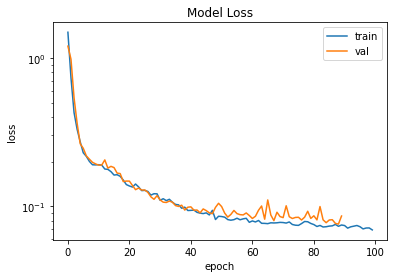

In [10]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


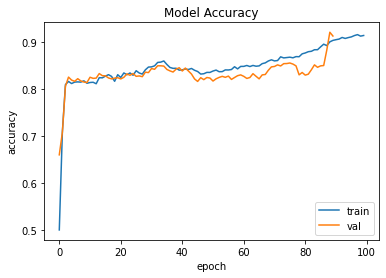

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()